In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Saving Copy of Copy of devnagari digit.zip to Copy of Copy of devnagari digit.zip
User uploaded file "Copy of Copy of devnagari digit.zip" with length 16649194 bytes
Extracted files: ['DevanagariHandwrittenDigitDataset']


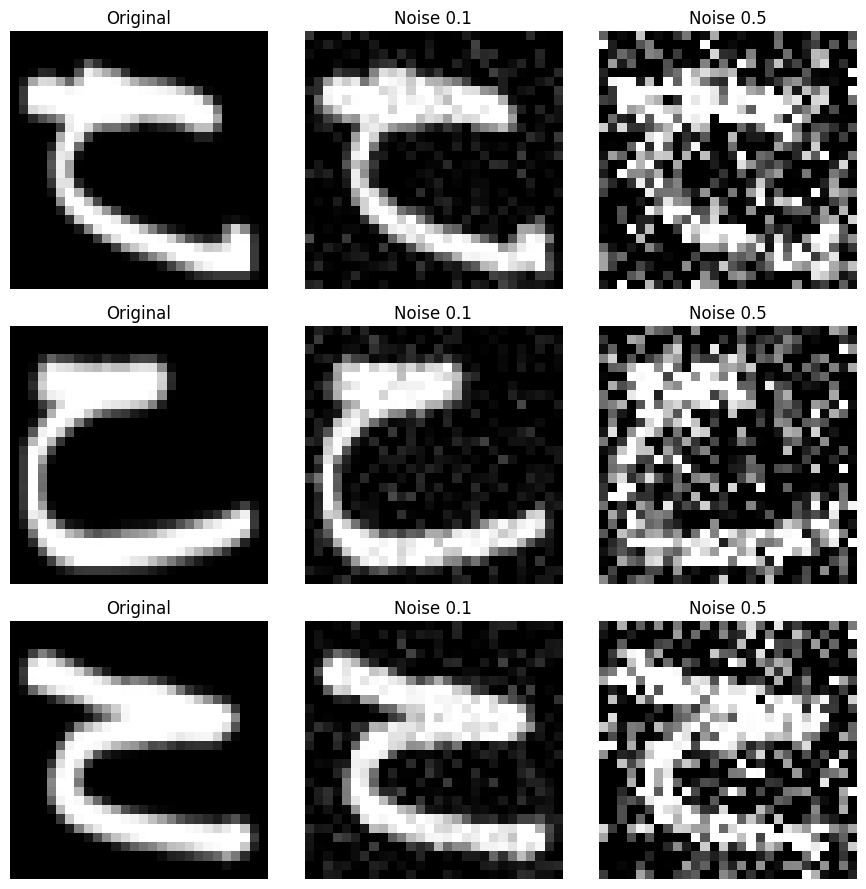

In [ ]:
import zipfile
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

dataset_dir = '/content/drive/MyDrive/AI and ML/Devnagari/DevanagariHandwrittenDigitDataset'

image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
            image_files.append(os.path.join(root, file))


X = []
for image_file in image_files:
    img = Image.open(image_file).convert('L')
    img = img.resize((28, 28))
    img = np.array(img) / 255.0
    X.append(img)

# Step 6: Convert list to numpy array and reshape for the model
X = np.array(X).reshape(-1, 28, 28, 1)

# Step 7: Add Gaussian noise to the dataset
noise_factor_low = 0.1
noise_factor_high = 0.5

X_noisy_low = X + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
X_noisy_high = X + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

# Clip pixel values to [0, 1]
X_noisy_low = np.clip(X_noisy_low, 0., 1.)
X_noisy_high = np.clip(X_noisy_high, 0., 1.)

# Step 8: Visualize the images (original and noisy)
n = 3  # Number of images to show
plt.figure(figsize=(9, 9))
for i in range(n):
    # Original image
    ax = plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Low noise image
    ax = plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(X_noisy_low[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')

    # High noise image
    ax = plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(X_noisy_high[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_encoder(input_shape=(28, 28, 1)):
    """
    Builds the encoder part of the convolutional autoencoder.
    Parameters:
        input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
    Returns:
        input_img (Keras Input): Input layer of the model.
        encoded (Keras Tensor): Encoded representation after convolution and pooling.
    """
    input_img = Input(shape=input_shape, name="input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    return input_img, encoded

def build_decoder(encoded_input):
    """
    Builds the decoder part of the convolutional autoencoder.
    Parameters:
        encoded_input (Keras Tensor): The output from the encoder.
    Returns:
        decoded (Keras Tensor): The reconstructed output after upsampling and convolution.
    """
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded

def build_autoencoder():
    """
    Constructs and compiles the full convolutional autoencoder by connecting encoder and decoder.
    Returns:
        autoencoder (Keras Model): Compiled autoencoder model.
    """
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

# Build and summarize the autoencoder model
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from sklearn.model_selection import train_test_split

# First, split the data
x_train, x_test = train_test_split(X, test_size=0.2, random_state=42)

# Then, apply noise
noise_factor_high = 0.5

x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to [0, 1]
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

# Now build and train the model
autoencoder = build_autoencoder()

history = autoencoder.fit(
    x_train_noisy_high, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_high, x_test)
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.4208 - val_loss: 0.2174
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2124 - val_loss: 0.2019
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2015 - val_loss: 0.1959
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1968 - val_loss: 0.1936
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1931 - val_loss: 0.1915
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1910 - val_loss: 0.1886
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1885 - val_loss: 0.1871
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1875 - val_loss: 0.1902
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1868 - val_loss: 0.1855
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1853 - val_loss: 0.1843


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


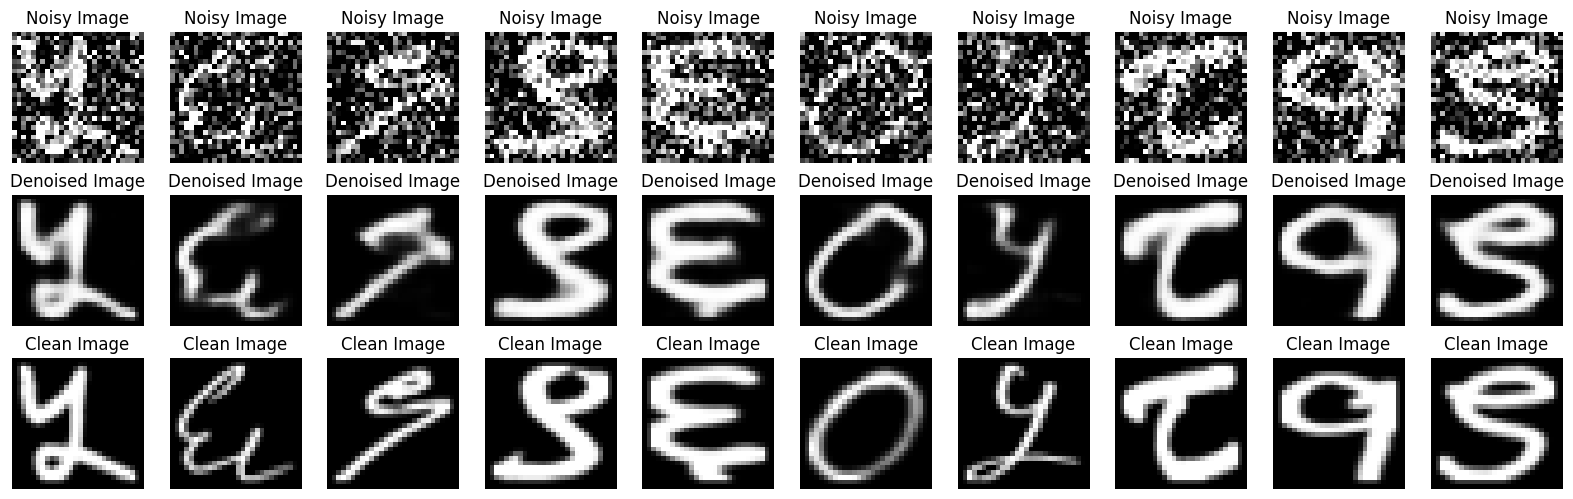

In [7]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)

# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Plot noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Plot denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Plot clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')

    plt.show()

# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)
